In [17]:
import math
from math import log, cos, sin

In [18]:
def ln(x):
    return log(x, math.e)

In [19]:
def func(x):
    return ln(cos(x*x)) + sin(x)

In [20]:
def d_func(x):
    return -(sin(x * x) * 2 * x) / cos(x*x) + cos(x)

In [21]:
def h_func(x):
    return (func(x+1e-9) - func(x)) / 1e-9

In [22]:
d_func(5)

1.618926255678585

In [23]:
h_func(5)

1.6189263263299836

In [24]:
def DFS(node):
    if not len(node.vars):
        return [node]
    ordered_vars = []
    for root in node.vars:
        ordered_vars += DFS(root)
    ordered_vars.append(node)
    return ordered_vars

def topological_DFS(node, visited=None, ordered_nodes=None, levels=None, level=None, key=lambda x: x.vars):
    if visited is None:
        visited = set()
    if ordered_nodes is None:
        ordered_nodes = []
    if levels is None:
        levels = []
    if level is None:
        level = 0

    if node not in visited:
        for root in key(node):
            topological_DFS(root, visited, ordered_nodes, levels, level + 1, key=key)
        ordered_nodes.append(node)
        levels.append(level)
        visited.add(node)
    return ordered_nodes, levels


In [25]:
sorted([("b", 2), ("a", 2)], key=lambda x: x[1])

[('b', 2), ('a', 2)]

In [26]:
def fff(*aa):
    print(len(aa), aa[0])

fff(1,2,5)

3 1


In [ ]:
import numpy as np

def im2col(input_tensor, filter_size, stride=1, padding=0):
    batch_size, num_channels, img_height, img_width = input_tensor.shape
    filter_height, filter_width = filter_size

    # Compute output dimensions
    out_height = (img_height + 2 * padding - filter_height) // stride + 1
    out_width = (img_width + 2 * padding - filter_width) // stride + 1

    # Add padding to the input
    if padding > 0:
        input_tensor = np.pad(
            input_tensor,
            ((0, 0), (0, 0), (padding, padding), (padding, padding)),
            mode='constant',
            constant_values=0
        )

    # Create the im2col matrix
    col_matrix = np.zeros((batch_size, num_channels, filter_height, filter_width, out_height, out_width))

    # Fill the im2col matrix
    for h in range(filter_height):
        for w in range(filter_width):
            col_matrix[:, :, h, w, :, :] = input_tensor[
                :, 
                :, 
                h:h + stride * out_height:stride, 
                w:w + stride * out_width:stride
            ]
    # Reshape to create the column matrix
    col_matrix = col_matrix.transpose(0, 4, 5, 1, 2, 3)  # (batch_size, out_height, out_width, num_channels, filter_height, filter_width)
    col_matrix = col_matrix.reshape(batch_size, out_height * out_width, -1)  # (batch_size, num_patches, num_channels * filter_height * filter_width)
    return col_matrix


def col2im(col_matrix, input_shape, filter_size, stride=1, padding=0):
    batch_size, num_channels, img_height, img_width = input_shape
    filter_height, filter_width = filter_size

    # Compute output dimensions
    out_height = (img_height + 2 * padding - filter_height) // stride + 1
    out_width = (img_width + 2 * padding - filter_width) // stride + 1

    # Initialize output tensor with zeros
    padded_height = img_height + 2 * padding
    padded_width = img_width + 2 * padding
    output = np.zeros((batch_size, num_channels, padded_height, padded_width))

    # Reshape col_matrix to extract patches
    col_matrix = col_matrix.reshape(batch_size, out_height, out_width, num_channels, filter_height, filter_width)
    col_matrix = col_matrix.transpose(0, 3, 4, 5, 1, 2)  # (batch_size, num_channels, filter_height, filter_width, out_height, out_width)

    # Accumulate gradients for each patch
    for h in range(filter_height):
        for w in range(filter_width):
            output[:, :, h:h + stride * out_height:stride, w:w + stride * out_width:stride] += col_matrix[:, :, h, w, :, :]

    # Remove padding if applied
    if padding > 0:
        output = output[:, :, padding:-padding, padding:-padding]

    return output


In [554]:
import uuid
import numpy as np

from collections.abc import Iterable

def eval_reduce_semi_broadcast_shape(og_shape, axis):
    if type(axis) not in [tuple, list]: axis=(axis,)
    shape_ls = list(og_shape) 
    for ax in axis: shape_ls[ax] = 1
    semi_broadcasted_shape = tuple(shape_ls)
    return semi_broadcasted_shape


def infer_reduction_axis(adjoint_shape, x_shape):
    return tuple([i for i, (dz_dim, v_dim) in enumerate(zip(adjoint_shape, x_shape)) if v_dim == 1 and dz_dim > 1])


class OpNode:
    NUMERIC_TYPES = [
        int, float, np.bool_, np.int8,
        np.int16, np.int32, np.int64, np.uint8,
        np.uint16, np.uint32, np.uint64, np.float16,
        np.float32, np.float64, np.complex64, np.complex128,
    ]
    CONSTANT_TYPES = NUMERIC_TYPES + [np.ndarray]

    def __init__(self, op, prefix="", constant=None, is_input=False, **kwargs):
        if op == "const" and constant is None:
            raise Exception("Const node needs to be assigned a value !!")
        self.name = f"[{prefix}]{op}_{str(uuid.uuid4())}"
        self.op = op
        self.vars = []
        self.leafs = set()
        self.val = constant
        self.adjoint = None
        self.kwargs = kwargs
        self.is_input = is_input
        self.inputs = []
        self.outputs = []
        self.frozen = False
        if "axis" in self.kwargs and type(self.kwargs["axis"]) not in [list, tuple]:
            self.kwargs["axis"] = (self.kwargs["axis"])

    def set_graph_inputs(self, inputs: list):
        self.inputs = inputs
        return self
    
    def append_graph_inputs(self, inputs: list):
        self.inputs = self.inputs + inputs
        return self
    
    def set_graph_outputs(self, outputs: list):
        self.outputs = outputs
        return self

    def substitute(self, val):
        self.val = val
        return self

    def __call__(self, *args):
        if len(args):
            self.vars = []
            for i, arg in enumerate(args):
                op_arg = arg
                if type(arg) in OpNode.CONSTANT_TYPES:
                    op_arg = OpNode("const", constant=arg)
                self.vars.append(op_arg)
                op_arg.leafs.add(self)
        return self

    @staticmethod
    def _add(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("*")(OpNode("const", constant=2), op_node2)
        res = OpNode("+")(op_node1, op_node2)
        return res
    
    def __add__(self, other): return OpNode._add(self, other)
    def __radd__(self, other): return OpNode._add(other, self)

    @staticmethod
    def _mul(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("**")(op_node2, OpNode("const", constant=2))
        res = OpNode("*")(op_node1, op_node2)
        return res
    
    def __mul__(self, other): return OpNode._mul(self, other)
    def __rmul__(self, other): return OpNode._mul(other, self)

    @staticmethod
    def _matmul(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        res = OpNode("@")(op_node1, op_node2)
        return res
    
    def __matmul__(self, other): return OpNode._matmul(self, other)
    def __rmatmul__(self, other): return OpNode._matmul(other, self)

    @staticmethod
    def _sub(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("const", constant=0)
        res = OpNode("-")(op_node1, op_node2)
        return res
    
    def __sub__(self, other): return OpNode._sub(self, other)
    def __rsub__(self, other): return OpNode._sub(other, self)
    
    @staticmethod
    def _truediv(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("const", constant=1)
        res = OpNode("/")(op_node1, op_node2)
        return res
    
    def __truediv__(self, other): return OpNode._truediv(self, other)
    def __rtruediv__(self, other): return OpNode._truediv(other, self)
    
    @staticmethod
    def __pow__(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        res = OpNode("**")(op_node1, op_node2)
        return res

    def __pow__(self, other): return OpNode._pow(self, other)
    def __rpow__(self, other): return OpNode._pow(other, self)

    def __neg__(self):
        return OpNode("neg")(self)

    def equals(self, other): return OpNode(op="==")(self, other)
    def sum(self, axis): return OpNode(op="+")(self, axis=axis)
    def prod(self, axis): return OpNode(op="*")(self, axis=axis)
    def transpose(self, axes): return OpNode(op="T")(self, axes=axes)
    def T(self, axes): return OpNode(op="T")(self, axes=axes)
    def max(self, axis): return OpNode(op="max")(self, axis=axis)
    def min(self, axis): return OpNode(op="min")(self, axis=axis)
    def reshape(self, shape): return OpNode(op="reshape")(self, shape=shape)

    def partial_derivative(self, with_respect_to):
        if not len(self.vars): return None
        if with_respect_to not in self.vars: return 0
        # if not len(self.leafs): return 1
        match(self.op):
            case "const":
                return 0
            case "neg":
                if type(self.val) == np.ndarray:
                    return -1 * np.ones(self.val.shape)
                return -1
            case "==" | "equals":
                if type(self.val) == np.ndarray:
                    return np.zeros(self.val.shape)
                return 0
            case "+" | "sum":
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                    return np.ones(self.vars[0].val.shape)
                count = 0
                for var in self.vars:
                    if var == with_respect_to:
                        count += 1
                if type(self.val) == np.ndarray:
                    return np.ones(self.vars[0].val.shape) * count
                return count
            case "-":
                scalar = 1
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: ## and self.vars[0] == with_respect_to
                        scalar = 0
                    elif self.vars[0] == with_respect_to:
                        scalar = 1
                    else:
                        scalar = -1
                    if type(self.val) == np.ndarray:
                        return np.ones(self.val.shape) * scalar
                    return scalar
                else: raise Exception("minus op only accepts two inputs")
            case "*" | "prod":
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                    semi_broadcasted_shape = eval_reduce_semi_broadcast_shape(
                        og_shape=self.vars[0].val.shape,
                        axis=self.kwargs["axis"],
                    )
                    return self.val.reshape(semi_broadcasted_shape) / self.vars[0].val
                count = 0
                for var in self.vars:
                    if var == with_respect_to:
                        count += 1
                return count * self.val / with_respect_to.val
            case "@" | "matmul":
                if type(self.vars[0].val) == np.ndarray and type(self.vars[1].val) == np.ndarray:
                    if self.vars[0] == with_respect_to:
                        ndim = self.vars[1].val.ndim
                        dims = list(range(ndim))
                        dims[-2], dims[-1] = dims[-1], dims[-2]
                        return self.vars[1].val.transpose(dims)
                    else:
                        ndim = self.vars[0].val.ndim
                        dims = list(range(ndim))
                        dims[-2], dims[-1] = dims[-1], dims[-2]
                        return self.vars[0].val.transpose(dims)
                else:
                    count = 0
                    for var in self.vars:
                        if var == with_respect_to:
                            count += 1
                    return count * self.val / with_respect_to.val
            case "/":
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: ## and self.vars[0] == with_respect_to
                        if type(self.val) == np.ndarray:
                            return np.zeros(self.val.shape)
                        return 0
                    if self.vars[0] == with_respect_to:
                        return 1 / self.vars[1].val
                    return -1 * self.vars[0].val / (with_respect_to.val ** 2)
                else: raise Exception("divide op only accepts two inputs")
            case "**":
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: ## and self.vars[0] == with_respect_to
                        return self.val * (1 + np.log(with_respect_to.val))
                    if self.vars[0] == with_respect_to:
                        return self.vars[1].val * self.val / with_respect_to.val
                    return self.val * np.log(self.vars[0].val)
                else: raise Exception("pow op only accepts two inputs")
            case "max":
                self_val = self.val
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                # if type(with_respect_to.val) == np.ndarray:
                    semi_broadcasted_shape = eval_reduce_semi_broadcast_shape(
                        og_shape=self.vars[0].val.shape,
                        axis=self.kwargs["axis"] if "axis" in self.kwargs else None,
                    )
                    self_val = self_val.reshape(semi_broadcasted_shape)
                return with_respect_to.val == self_val
            case "min": 
                self_val = self.val
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                    semi_broadcasted_shape = eval_reduce_semi_broadcast_shape(
                        og_shape=self.vars[0].val.shape,
                        axis=self.kwargs["axis"] if "axis" in self.kwargs else None,
                    )
                    self_val = self_val.reshape(semi_broadcasted_shape)
                return with_respect_to.val == self_val
            case "transpose" | "T":
                if type(with_respect_to.val) == np.ndarray:
                    return np.ones(with_respect_to.val.shape)
                return 1
            case "reshape":
                if type(with_respect_to.val) == np.ndarray:
                    return np.ones(with_respect_to.val.shape)
                return 1
            case "ln": return 1 / with_respect_to.val ## and self.vars[0] == with_respect_to
            case "log10": return 1 / (with_respect_to.val * np.log(10))
            case "log2": return 1 / (with_respect_to.val * np.log(2))
            case "cos": return -np.sin(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "sin": return np.cos(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "tan": return 1 / (np.cos(with_respect_to.val) ** 2) ## and self.vars[0] == with_respect_to
            case "cosh": return np.sinh(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "sinh": return np.cosh(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "tanh": return 1 / (np.cosh(with_respect_to.val) ** 2) ## and self.vars[0] == with_respect_to
            case "sqrt": return 1 / (2 * self.val) ## and self.vars[0] == with_respect_to
            case "exp": return self.val
            case _:
                return self.vars[0].val

    def compute_adjoint(self):
        if not len(self.leafs):
            if self.adjoint is None:
                self.adjoint = 1
            return
        if self.adjoint is None:
            self.adjoint = 0
        for leaf in self.leafs:
            if leaf.adjoint is not None:
                match (leaf.op):
                    case "@" | "matmul":
                        if self == leaf.vars[0]: self.adjoint += leaf.adjoint @ leaf.partial_derivative(self)
                        else: self.adjoint += leaf.partial_derivative(self) @ leaf.adjoint
                    case "sum"|"prod"|"+"|"*"|"max"|"min":
                        partial_derivative = leaf.partial_derivative(self)
                        broadcasted_adjoint = leaf.adjoint
                        if len(leaf.vars) == 1 :
                            if type(self.val) == np.ndarray: 
                                reshaped_leaf_adjoint = leaf.adjoint
                                if type(leaf.adjoint) == np.ndarray:
                                    reshaped_leaf_adjoint = leaf.adjoint.reshape(partial_derivative.shape)
                                broadcasted_adjoint = np.broadcast_to(reshaped_leaf_adjoint, self.val.shape)

                        self.adjoint += broadcasted_adjoint * partial_derivative
                        if len(leaf.vars) == 2:
                            if type(leaf.adjoint) == np.ndarray and type(self.val) != np.ndarray:
                                axes = infer_reduction_axis(
                                    leaf.adjoint.shape,
                                    self.val.shape if type(self.val) == np.ndarray else len(leaf.adjoint.shape)*[1]
                                )
                                self.adjoint = np.sum(self.adjoint, axis=axes)
                            elif (type(self.val) == np.ndarray and self.val.shape != leaf.adjoint.shape):
                                axes = infer_reduction_axis(
                                    leaf.adjoint.shape,
                                    self.val.shape if type(self.val) == np.ndarray else len(leaf.adjoint.shape)*[1]
                                )
                                self.adjoint = np.sum(self.adjoint, axis=axes)
                    case "transpose" | "T": self.adjoint += leaf.adjoint.transpose(leaf.kwargs["axes"]) * leaf.partial_derivative(self)
                    case "reshape": self.adjoint += leaf.adjoint.reshape(self.val.shape) * leaf.partial_derivative(self)
                    case _: self.adjoint += leaf.adjoint * leaf.partial_derivative(self)
    
    def compute(self):
        if not len(self.vars): return
        match(self.op):
            case "const": return
            case "neg":
                if len(self.vars) > 1: raise Exception("negation op only takes one input")
                self.val = -1 * self.vars[0].val
            case "==" | "equals":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray and self.vars[0].val.shape != self.vars[1].val.shape:
                            raise Exception("inputs have mismatching shapes")
                        self.val = self.vars[0].val.shap != self.vars[1].val
                    else: raise Exception("inputs have mismatching types")
                else: raise Exception("equals op only accepts two inputs")
            case "+" | "sum":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.sum(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    summ = 0
                    for root in self.vars:
                        print(root, root.val.shape)
                    for root in self.vars:
                        summ += root.val
                    self.val = summ
            case "-":
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: self.val = 0
                    else: self.val = self.vars[0].val - self.vars[1].val
                else: raise Exception("minus op only accepts two inputs")
            case "*" | "prod":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.prod(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    prod = 1
                    for root in self.vars:
                        prod *= root.val
                    self.val = prod
            case "@" | "matmul":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray: self.val = self.vars[0].val.dot(self.vars[1].val)
                        else: self.val = self.vars[0].val * self.vars[1].val
                    else: raise Exception("mismatching input types in matmul")
                else: raise Exception("matmul op only accepts two inputs")
            case "/":
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: self.val = 1
                    else: self.val = self.vars[0].val / self.vars[1].val
                else: raise Exception("divide op only accepts two inputs")
            case "**":
                if len(self.vars) == 2:
                    base = self.vars[0].val
                    power = self.vars[1].val
                    self.val = base ** power
                else: raise Exception("pow op only accepts two inputs")
            case "max":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.max(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    if any(map(lambda var: type(var.val) == np.ndarray, self.vars)):
                        if len(self.vars) > 2: raise Exception("You can only compare two ndarrays using max op !")
                        self.val = np.maximum(self.vars[0].val, self.vars[1].val)
                    else: self.val = max(list(map(lambda var: var.val, self.vars)))
            case "min":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.min(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    if any(map(lambda var: type(var.val) == np.ndarray, self.vars)):
                        if len(self.vars) > 2: raise Exception("You can only compare two ndarrays using min op !")
                        self.val = np.minimum(self.vars[0].val, self.vars[1].val)
                    else: self.val = min(list(map(lambda var: var.val, self.vars)))
            case "transpose" | "T":
                if len(self.vars) != 1: raise Exception("transpose operation only takes one tensor input")
                if type(self.vars[0]) == np.ndarray:
                    if "axes" in self.kwargs:
                        self.val = self.vars[0].val.transpose(self.kwargs["axes"])
                    else:
                        self.val = self.vars[0].val.T
                else:
                    self.val = self.vars[0].val
            case "reshape":
                if len(self.vars) != 1: raise Exception("reshape operation only takes one tensor input")
                if type(self.vars[0]) == np.ndarray:
                    if "shape" in self.kwargs:
                        self.val = self.vars[0].val.reshape(self.kwargs["shape"])
                    else:
                        raise Exception("reshape function requires a tuple as an arg")
                else:
                    self.val = self.vars[0].val
            case "ln": self.val = np.log(self.vars[0].val, **self.kwargs)
            case "log10": self.val = np.log10(self.vars[0].val, **self.kwargs)
            case "log2": self.val = np.log2(self.vars[0].val, **self.kwargs)
            case "cos": self.val = np.cos(self.vars[0].val, **self.kwargs)
            case "sin": self.val = np.sin(self.vars[0].val, **self.kwargs)
            case "tan": self.val = np.tan(self.vars[0].val, **self.kwargs)
            case "cosh": self.val = np.cosh(self.vars[0].val, **self.kwargs)
            case "sinh": self.val = np.sinh(self.vars[0].val, **self.kwargs)
            case "tanh": self.val = np.tanh(self.vars[0].val, **self.kwargs)
            case "sqrt": self.val = np.sqrt(self.vars[0].val, **self.kwargs)
            case "exp": self.val = np.exp(self.vars[0].val, **self.kwargs)
            case _:
                raise Exception("Invalid Operation !!")
        return self.val

    def graph_forward(self, input_values=[], local_inputs_only=False):
        if not len(self.inputs): raise Exception("Cannont compute result of graph without setting the graph input nodes")
        if len(self.inputs) != len(input_values): raise Exception("input length mismatch")
        for input_node, input_value in zip(self.inputs, input_values):
            input_node.substitute(input_value)
        ordered_operations, _ = topological_DFS(self)
        if local_inputs_only:
            limited_operations = []
            num_input_found = 0
            for op in ordered_operations[::-1]:
                if op in self.inputs:
                    num_input_found += 1
                    if num_input_found < len(self.inputs): continue
                    else: break
                limited_operations.append(op)
            ordered_operations = reversed(limited_operations)

        for op in ordered_operations:
            op.compute()
            # print(op, ":", op.val)

        return self.val
    
    def graph_backward(self, y_adjoint=None):
        if y_adjoint is not None: self.adjoint = y_adjoint
        ordered_operations, _ = topological_DFS(self)
        if any(map(lambda node: node.val is None, ordered_operations)):
            raise Exception("Forward pass didnt fill in all of the values of the nodes")
        
        trainable_params = []
        gradients = []
        for op in reversed(ordered_operations):
            if op.is_input: continue
            if op != self or y_adjoint is None:
                op.adjoint = None
                op.compute_adjoint()
            # print(op, "ADJOINT:", op.adjoint.shape if type(op.adjoint) == np.ndarray else op.adjoint)
            if not op.is_input and op.op == "var" and not op.frozen:
                trainable_params.append(op)
                gradients.append(op.adjoint)

        return trainable_params, gradients
    
    def graph_freeze(self, local_inputs_only=True):
        if local_inputs_only and not len(self.inputs): raise Exception("Cannont freeze local inputs, without defining the local inputs of the graph")
        ordered_operations, _ = topological_DFS(self)
        if local_inputs_only:
            limited_operations = []
            num_input_found = 0
            for op in ordered_operations[::-1]:
                if op in self.inputs:
                    num_input_found += 1
                    if num_input_found < len(self.inputs): continue
                    else: break
                limited_operations.append(op)
            ordered_operations = reversed(limited_operations)

        for op in ordered_operations:
            op.frozen = True

        return self

    def reset_gradients(self):
        ordered_operations, _ = topological_DFS(self)
        for op in ordered_operations:
            op.adjoint = None
            
    def backpropagate(self, callback):
        ordered_operations, _ = topological_DFS(self)
        if any(map(lambda node: node.val is None, ordered_operations)):
            raise Exception("Forward pass didnt fill in all of the values of the nodes")
        
        for op in reversed(ordered_operations):
            if op.is_input or op.op != "var" or op.frozen: continue
            callback(op)
            # print(f"[{op}] adjoint:", op.adjoint)
            # print("---------------------")
        
    def __hash__(self):
        return hash((self.name))

    def __eq__(self, other):
        return isinstance(other, OpNode) and self.name == other.name and self.op == other.op
    
    def __repr__(self) -> str:
        lim = len(self.op) + 14
        name = self.name[:lim]
        is_input = ""
        if self.op == "var" and self.is_input:
            is_input = "[input]"
        return f"{name}({self.op})" + is_input

In [555]:
infer_reduction_axis((32, 10), len((32, 10))*[1])

(0, 1)

In [556]:
from typing import Union, List
from abc import ABC, abstractmethod
import numpy as np

TYPES = Union[
    OpNode, int, float, np.bool_, np.int8,
    np.int16, np.int32, np.int64, np.uint8,
    np.uint16, np.uint32, np.uint64, np.float16,
    np.float32, np.float64, np.complex64, np.complex128,
    np.ndarray
]

def var(initial_val=None, is_input=False, prefix=""):
    x = OpNode(op="var", is_input=is_input, prefix=prefix)
    if initial_val is not None:
        x.substitute(initial_val)
    return x

def const(val):
    return OpNode(op="const", constant=val)

def sigmoid(X: OpNode = None, axis=-1):
    if X is None:
        X = var()
    sig = 1 / (1 + OpNode(op="exp", axis=axis)(-X))
    return sig.set_graph_inputs(inputs=[X])

# (b, c, w, h)
# (k, c, k_w, k_h)
# (b, k, (w - k_w + 2 * p) / s, (h - k_h + 2 * p) / s)

class Layer(ABC):
    def __init__(self, shape=None):
        self.shape: tuple = shape
        self.output_node: OpNode = None
        self.previous_layers = []

    def get_output_shape_(self): return self.shape
    
    def get_output_node_(self): return self.output_node

    @abstractmethod
    def __call__(self): pass

    @abstractmethod
    def forward(self): pass

    @abstractmethod
    def backward(self, y_grad=None): pass

    def __repr__(self):
        if_activation = ""
        if hasattr(self, 'activation'):
            if_activation = " | " + str(type(self.activation))
        return "Layer: " + str(type(self)) + " | " + str(self.get_output_shape_()) + if_activation

class ReLU:
    def __init__(self):
        pass

    def __call__(self, X_node: OpNode, prefix=""):
        self.y_node = OpNode(op="max", prefix=prefix)(0, X_node).set_graph_inputs(inputs=[X_node])
        return self.y_node

    def forward(self, X):
        return self.y_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass
    
class Sigmoid:
    def __init__(self):
        super().__init__()

    def __call__(self, X_node: OpNode, prefix=""):
        self.y_node = 1 / (1 + OpNode(op="exp", prefix=prefix)(-X_node))
        self.y_node.set_graph_inputs(inputs=[X_node])
        return self.y_node
    
    def forward(self, X):
        return self.y_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Softmax:
    def __init__(self, axis=-1):
        super().__init__()
        self.axis = axis

    def __call__(self, X_node: OpNode, prefix=""):
        exp_node = OpNode(op="exp", prefix=prefix)(X_node - OpNode(op="max", axis=self.axis, keepdims=True, prefix=prefix)(X_node))
        self.y_node = exp_node / OpNode(op="sum", axis=self.axis, keepdims=True, prefix=prefix)(exp_node)
        self.y_node.set_graph_inputs(inputs=[X_node])
        return self.y_node
    
    def forward(self, X):
        return self.y_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass


def softmax(x):
    # Shift the input by the max value for numerical stability
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    # Normalize along the last axis
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

    
class Input(Layer):
    def __init__(self, shape):
        super().__init__(shape=shape)
        self.output_node = var(is_input=True)
    
    def __call__(self): 
        return self

    def forward(self, X): return X 

    def backward(self, y_grad=None): pass

class Dense(Layer):
    def __init__(self, units, activation = None, name=""):
        self.units = units
        self.activation = activation
        self.name = name

    def __call__(self, entry: Layer):
        self.previous_layers = [entry]
        input_shape = entry.get_output_shape_()
        self.shape = (input_shape[-1], self.units)
        W = np.random.randn(self.shape[0], self.shape[1]) * np.sqrt(2. / self.shape[0])
        # W = np.random.uniform(
        #     low=-np.sqrt(1 / self.shape[0]), high=np.sqrt(1 / self.shape[0]), size=(self.shape[0], self.shape[1])
        # )
        b = np.zeros((1, self.shape[1]))
        print(entry)
        print(entry.get_output_node_())
        self.X_node = entry.get_output_node_()
        self.W_node = var(initial_val=W, prefix=self.name)
        self.b_node = var(initial_val=b, prefix=self.name)
        self.z_node = OpNode(op="+", prefix=self.name)(OpNode(op="matmul", prefix=self.name)(self.X_node, self.W_node), self.b_node)
        self.output_node = self.activation(self.z_node, prefix=self.name)
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self

    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])

    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class LossFunction(ABC):
    @abstractmethod
    def __call__(self): pass

    @abstractmethod
    def evaluate(self, y): pass


class CategoricalCrossEntropy(LossFunction):
    def __init__(self, epsilon=1e-15, axis=None):
        self.epsilon = epsilon
        self.axis = axis
        self.loss_node: OpNode = None
        
    def __call__(self, output: Layer):
        self.y_node = var(is_input=True)
        self.batch_size_node = var(is_input=True)
        self.preds_node = output.get_output_node_()
        self.preds_node_epsilon = OpNode(op="max")(self.preds_node, self.epsilon)
        self.preds_node_epsilon = OpNode(op="min")(self.preds_node_epsilon, 1 - self.epsilon)
        self.loss_node = -OpNode(op="+", axis=self.axis)(self.y_node * OpNode(op="ln")(self.preds_node_epsilon)) / self.batch_size_node
        return self

    def evaluate(self, y):
        self.loss_node.set_graph_inputs(inputs=[self.preds_node, self.y_node, self.batch_size_node])
        if self.preds_node.val is None: raise Exception("Model output is None, check if inference was executed correctly !!")
        return self.loss_node.graph_forward(input_values=[self.preds_node.val, y, y.shape[0]], local_inputs_only=True)

class Optimizer(ABC):
    @abstractmethod
    def update_node(self, node: OpNode): pass

    @abstractmethod
    def update_graph(self, nodes: List[OpNode], gradients: list): pass

def batch_numpy_array(dataset: np.ndarray, batch_size: int):
    padding_length = (batch_size - len(dataset) % batch_size) % batch_size
    indices = np.random.choice(dataset.shape[0], size=padding_length)
    padding = dataset[indices]
    padded_dataset = np.concatenate((dataset, padding), axis=0)
    return padded_dataset.reshape((-1, batch_size, *padded_dataset.shape[1:]))

class Model:
    def __init__(self, inputs: List[Layer], output: Layer):
        self.inputs = inputs
        self.output = output
        self.input_nodes = [input.get_output_node_() for input in self.inputs]
        self.output.get_output_node_().set_graph_inputs(inputs=self.input_nodes)
        self.layers, _ = topological_DFS(self.output, key=lambda x: x.previous_layers)
        self.loss = None
        self.optimizer = None

    def summary(self):
        print("="*90)
        print("-"*90)
        print("|| Layer\t\t\t|| Shape\t|| Activation\t\t||")
        for layer in self.layers:
            print("-"*90)
            print(layer)
        print("="*90)
        print("Loss Functions:", str(type(self.loss)))
        print("*"*90)
        print("Optimizer:", str(type(self.optimizer)))

    def set_loss_function(self, loss: LossFunction):
        self.loss = loss(self.output)
        return self

    def set_optimizer(self, optimizer: Optimizer):
        self.optimizer = optimizer
        return self
    
    def train_batch(self, x_train_inputs: list, y_train):
        _ = self.output.get_output_node_().graph_forward(input_values=x_train_inputs)
        loss = self.loss.evaluate(y_train)
        print("Batch loss:", loss)
        trainable_params, gradients = self.loss.loss_node.graph_backward()
        self.optimizer.update_graph(trainable_params, gradients)
        # for i, (weights_node, gradient) in enumerate(zip(trainable_params, gradients)):
        #     # if i == 0:
        #     #     print(
        #     #         weights_node, "=>",
        #     #         "trainable:", weights_node.val,
        #     #         "grad", gradient
        #     #     )
        #     self.optimizer.update_node(weights_node, gradient)

        return loss

    def fit(self, x_inputs: list, y, epochs, x_val_inputs: list=None, y_val=None, batch_size=32):
        batched_x_inputs = [batch_numpy_array(dataset=x_input, batch_size=batch_size) for x_input in x_inputs]
        batched_y = batch_numpy_array(dataset=y, batch_size=batch_size)
        print("X.shape:", batched_x_inputs[0].shape)
        print("y.shape:", batched_y.shape)
        for i in range(1, epochs + 1):
            print(f"Epochs: {i}/{epochs}")
            print("="*70)
            epoch_loss = 0
            for batch_tup in zip(*([*batched_x_inputs, batched_y])):
                y_batch = batch_tup[-1]
                input_batch = batch_tup[:-1]
                loss = self.train_batch(input_batch, y_batch)
                epoch_loss += loss
            print("-"*70)
            epoch_loss = epoch_loss / len(batched_y)
            print("Loss:", epoch_loss)
            print("-"*70)
            self.optimizer.lr *= 0.1


    def predict(self, x_inputs: list):
        logits = self.output.get_output_node_().graph_forward(input_values=[x for x in x_inputs])
        return logits


class SGD(Optimizer):
    def __init__(self, lr=1e-4, gradient_max_norm=1.0):
        self.lr = lr
        self.max_norm = gradient_max_norm

    def update_node(self, node: OpNode, gradient):
        self.max_norm = 1
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > self.max_norm:
            gradient = gradient * (self.max_norm / gradient_norm)
        node.val = node.val - self.lr * gradient

    def update_graph(self, nodes: List[OpNode], gradients: list):
        for node, gradient in zip(nodes, gradients):
            self.update_node(node, gradient)

class Adam(Optimizer):
    def __init__(self, lr=1e-4, beta1=0.9, beta2=0.999, epsilon=1e-8, gradient_max_norm=1.0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.max_norm = gradient_max_norm
        self.m = {}  # First moment vector (mean of gradients)
        self.v = {}  # Second moment vector (variance of gradients)
        self.t = 0   # Time step for bias correction

    def update_node(self, node: OpNode, gradient):
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > self.max_norm:
            gradient = gradient * (self.max_norm / gradient_norm)

        # print(np.linalg.norm(gradient))

        if node not in self.m:
            self.m[node] = np.zeros_like(gradient)
            self.v[node] = np.zeros_like(gradient)

        self.m[node] = self.beta1 * self.m[node] + (1 - self.beta1) * gradient
        self.v[node] = self.beta2 * self.v[node] + (1 - self.beta2) * (gradient ** 2)

        m_hat = self.m[node] / (1 - self.beta1 ** self.t)
        v_hat = self.v[node] / (1 - self.beta2 ** self.t)

        node.val -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def update_graph(self, nodes: List[OpNode], gradients: list):
        # gradient_norms = [np.linalg.norm(gradient) for gradient in gradients]
        # print(gradient_norms)
        self.t += 1
        for node, gradient in zip(nodes, gradients):
            self.update_node(node, gradient)



In [557]:
(np.ones((1, 50)) + np.ones((50,)))

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2.]])

In [597]:
inp = Input((784,))
dense_1 = Dense(units=1024, activation=ReLU(), name="dense1")(inp)
dense_2 = Dense(units=1024, activation=ReLU(), name="dense2")(dense_1)
# dense_3 = Dense(units=128, activation=ReLU(), name="dense3")(dense_2)
# dense_4 = Dense(units=128, activation=ReLU(), name="dense4")(dense_3)
out = Dense(units=10, activation=Softmax(), name="dense3")(dense_2)

model = Model(inputs=[inp], output=out)

model.set_loss_function(CategoricalCrossEntropy()).set_optimizer(Adam(lr=1e-5))

model.summary()


Layer: <class '__main__.Input'> | (784,)
[]var_1dfb3451-9c(var)[input]
Layer: <class '__main__.Dense'> | (784, 1024) | <class '__main__.ReLU'>
[dense1]max_ed9a0(max)
Layer: <class '__main__.Dense'> | (1024, 1024) | <class '__main__.ReLU'>
[dense2]max_0935d(max)
------------------------------------------------------------------------------------------
|| Layer			|| Shape	|| Activation		||
------------------------------------------------------------------------------------------
Layer: <class '__main__.Input'> | (784,)
------------------------------------------------------------------------------------------
Layer: <class '__main__.Dense'> | (784, 1024) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: <class '__main__.Dense'> | (1024, 1024) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: <class '__main__.Dense'> | (1024, 10) | <class '__ma

In [598]:
import tensorflow as tf
from keras.utils import to_categorical

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# The images are already in NumPy array format, but let's ensure they are float32
train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

# Normalize the images to the range [0, 1]
train_images /= 255.0
test_images /= 255.0

train_images = train_images.reshape(-1, 784)

# Assume train_labels and test_labels are already loaded
train_labels_one_hot = to_categorical(train_labels).astype('float64')
test_labels_one_hot = to_categorical(test_labels).astype('float64')

print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

print("One-Hot Encoded Training Labels Shape:", train_labels_one_hot.shape)
print("One-Hot Encoded Test Labels Shape:", test_labels_one_hot.shape)


Training images shape: (60000, 784)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
One-Hot Encoded Training Labels Shape: (60000, 10)
One-Hot Encoded Test Labels Shape: (10000, 10)


In [599]:
np.random.randn(5,5).dtype

dtype('float64')

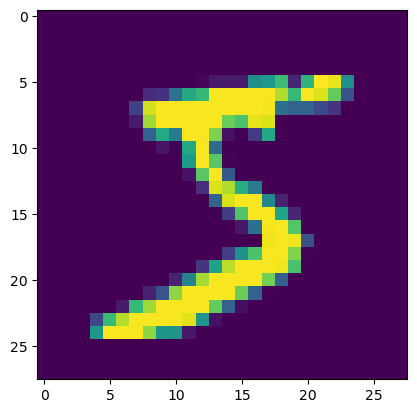

In [600]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0].reshape(28, 28))

In [601]:
train_labels_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [602]:
model.fit(x_inputs=[train_images], y=train_labels_one_hot, batch_size=32, epochs=5)

X.shape: (1875, 32, 784)
y.shape: (1875, 32, 10)
Epochs: 1/5
[dense1]matmul_06109(matmul) (32, 1024)
[dense1]var_9adca(var) (1, 1024)
[dense2]matmul_99fa8(matmul) (32, 1024)
[dense2]var_09e72(var) (1, 1024)
[dense3]matmul_646c9(matmul) (32, 10)
[dense3]var_99818(var) (1, 10)
[dense1]matmul_06109(matmul) (32, 1024)
[dense1]var_9adca(var) (1, 1024)
[dense2]matmul_99fa8(matmul) (32, 1024)
[dense2]var_09e72(var) (1, 1024)
[dense3]matmul_646c9(matmul) (32, 10)
[dense3]var_99818(var) (1, 10)
Batch loss: 2.4081172309662087
[dense1]matmul_06109(matmul) (32, 1024)
[dense1]var_9adca(var) (1, 1024)
[dense2]matmul_99fa8(matmul) (32, 1024)
[dense2]var_09e72(var) (1, 1024)
[dense3]matmul_646c9(matmul) (32, 10)
[dense3]var_99818(var) (1, 10)
[dense1]matmul_06109(matmul) (32, 1024)
[dense1]var_9adca(var) (1, 1024)
[dense2]matmul_99fa8(matmul) (32, 1024)
[dense2]var_09e72(var) (1, 1024)
[dense3]matmul_646c9(matmul) (32, 10)
[dense3]var_99818(var) (1, 10)
Batch loss: 2.3918542026720666
[dense1]matmul_06

In [552]:
len(test_images[0].reshape(-1))

784

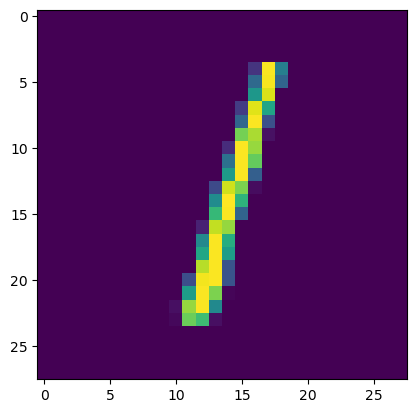

In [ ]:
plt.imshow(test_images[3])

[dense1]matmul_06109(matmul) (10000, 1, 1024)
[dense1]var_9adca(var) (1, 1024)
[dense2]matmul_99fa8(matmul) (10000, 1, 1024)
[dense2]var_09e72(var) (1, 1024)
[dense3]matmul_646c9(matmul) (10000, 1, 10)
[dense3]var_99818(var) (1, 10)


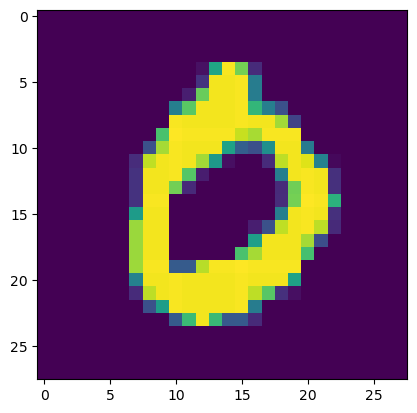

In [603]:
plt.imshow(test_images[3])
preds = np.argmax(model.predict(x_inputs=[test_images.reshape(-1, 1, 784)]), axis=-1)

In [604]:
sum(preds.reshape(-1) == test_labels) / len(test_labels)

0.799

In [589]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [22]:
import numpy as np

# Define the softmax function with axis argument
def _softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))  # Subtract max for numerical stability
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Example usage
X = np.array([[2.0, 1.0, 0.1],
              [1.0, 2.0, 0.1]])

_softmax(X, axis=-1)


array([[0.65900114, 0.24243297, 0.09856589],
       [0.24243297, 0.65900114, 0.09856589]])

In [175]:
x = OpNode("var")
y = OpNode("ln")(OpNode("cos")(x * x)) + OpNode("sin")(x)
y.vars

[[]ln_5e94ded3-b2(ln), []sin_e623ff79-ae(sin)]

In [176]:
x_sub = 1

x.substitute(x_sub)

ordered_operations, _ = topological_DFS(y)

for op in ordered_operations:
    op.compute()
    print(op, ":", op.val)

print("-"*50)
print(func(x_sub))

[]var_2a745d76-a8(var) : 1
[]const_7ff5cccb-9f(const) : 2
[]**_a7fb4035-f7(**) : 1
[]cos_7028ed90-b9(cos) : 0.5403023058681398
[]ln_5e94ded3-b2(ln) : -0.6156264703860141
[]sin_e623ff79-ae(sin) : 0.8414709848078965
[]+_653df75c-54(+) : 0.22584451442188236
--------------------------------------------------
0.22584451442188236


In [177]:
for op in reversed(ordered_operations):
    op.adjoint = None
    op.compute_adjoint()
    print(f"[{op}] adjoint:", op.adjoint)
    print("---------------------")

print("="*50)
print(d_func(x_sub))

[[]+_653df75c-54(+)] adjoint: 1
---------------------
+++ []sin_e623ff79-ae(sin)
[[]sin_e623ff79-ae(sin)] adjoint: 1
---------------------
+++ []ln_5e94ded3-b2(ln)
[[]ln_5e94ded3-b2(ln)] adjoint: 1
---------------------
+++ []cos_7028ed90-b9(cos)
[[]cos_7028ed90-b9(cos)] adjoint: 1.8508157176809255
---------------------
+++ []**_a7fb4035-f7(**)
[[]**_a7fb4035-f7(**)] adjoint: -1.557407724654902
---------------------
+++ []const_7ff5cccb-9f(const)
[[]const_7ff5cccb-9f(const)] adjoint: 0.0
---------------------
+++ []var_2a745d76-a8(var)
+++ []var_2a745d76-a8(var)
[[]var_2a745d76-a8(var)] adjoint: -2.5745131434416644
---------------------
-2.5745131434416644


In [137]:
(2 * OpNode("var")).vars

[const_55f(const), var_513(var)]

In [178]:
x1 = OpNode("var")
x2 = OpNode("var")
y_ = OpNode("ln")(OpNode("cos")(x1 * x2)) + OpNode("sin")(x1) + 2 * x2

y_.vars, y_.leafs

([[]+_92be5ef1-7c(+), []*_65038e37-ed(*)], set())

In [83]:
# v1 = x1 * x2
# v2 = cos(v1)
# v3 = ln(v2)
# v4 = sin(x1)
# v5 = 2 * x2
# v6 = v5 + v4
# v7 = v3 + v6

# av7 = 1
# av6 = av7 * dv7 / dv6 = 1 * 1 = 1
# av5 = av6 * dv6 / dv5 = 1 * 1 = 1
# av4 = av6 * dv6 / dv4 = 1 * 1 = 1
# av3 = av7 * dv7 / dv3 = 1 * 1 = 1
# av2 = av3 * dv3 / dv2 = 1 / v2
# av1 = av2 * dv2 / dv1 = -sin(v1)
# ax2 = av1 * dv1 / dx2 + av5 * dv5 / dx2 = x1 + 2
# ax1 = av1 * dv1 / dx1 + av4 * dv4 / dx1 = x2 + cos(x1)


In [179]:
topological_DFS(y_)

([[]var_050142af-7b(var),
  []var_d0e192b3-0f(var),
  []*_ba213ca3-6c(*),
  []cos_3d837e6c-1a(cos),
  []ln_bdc44662-2f(ln),
  []sin_b897be66-ff(sin),
  []+_92be5ef1-7c(+),
  []const_6af07832-02(const),
  []*_65038e37-ed(*),
  []+_8a6084ba-9f(+)],
 [5, 5, 4, 3, 2, 2, 1, 2, 1, 0])

In [180]:
x1.substitute(5)
x2.substitute(9)

for op in DFS(y_):
    # print(op)
    op.compute()
    print(op, ":", op.val)

[]var_050142af-7b(var) : 5
[]var_d0e192b3-0f(var) : 9
[]*_ba213ca3-6c(*) : 45
[]cos_3d837e6c-1a(cos) : 0.5253219888177297
[]ln_bdc44662-2f(ln) : -0.6437438923557037
[]var_050142af-7b(var) : 5
[]sin_b897be66-ff(sin) : -0.9589242746631385
[]+_92be5ef1-7c(+) : -1.6026681670188423
[]const_6af07832-02(const) : 2
[]var_d0e192b3-0f(var) : 9
[]*_65038e37-ed(*) : 18
[]+_8a6084ba-9f(+) : 16.39733183298116


In [18]:

DFS(y_)[7].vars, DFS(y_)[7].vars[0].val, DFS(y_)[7].vars[1].val

([ln_f1e(ln), sin_c38(sin)], -0.6437438923557037, -0.9589242746631385)

In [12]:
DFS(y_)[2].leafs

[cos_f7e(cos)]

In [13]:
xx1 = 5
xx2 = 9

ln(cos(xx1 * xx2)) + sin(xx1) + 2 * xx2

16.39733183298116

In [108]:
x.substitute(5)
x.val

5

In [181]:
import networkx as nx
import matplotlib.pyplot as plt

def extract_edges(node, visited=None):
    if visited is None:
        visited = set()
    edges = []
    if node in visited:
        return edges
    visited.add(node)
    for leaf in node.vars:
        lim = len(node.op) + 5
        name = node.name[:lim]
        l_lim = len(leaf.op) + 5
        l_name = leaf.name[:l_lim]
        edges.append((name, l_name))
        edges.extend(extract_edges(leaf, visited))
    return edges

In [183]:
pip show networkx

Name: networkx
Version: 3.3
Summary: Python package for creating and manipulating graphs and networks
Home-page: https://networkx.org/
Author: 
Author-email: Aric Hagberg <hagberg@lanl.gov>
License: 
Location: c:\Users\oussa\anaconda3\Lib\site-packages
Requires: 
Required-by: intake, scikit-image
Note: you may need to restart the kernel to use updated packages.


In [189]:
len(edges)

29

In [197]:
import networkx as nx

def remove_cycles(edges):
    # Create a directed graph from the list of edges
    G = nx.DiGraph(edges)

    try:
        # Find a cycle in the graph
        cycle = nx.find_cycle(G, orientation='original')
        while cycle:
            # Remove one edge from the cycle (use source and target nodes only)
            G.remove_edge(cycle[0][0], cycle[0][1])
            print(f"Removed edge: {cycle[0][0]} -> {cycle[0][1]}")
            # Try to find another cycle
            cycle = nx.find_cycle(G, orientation='original')
    except nx.exception.NetworkXNoCycle:
        pass

    return G

def no_cycle_graph(G):
    G = nx.DiGraph(list(G.edges))
    try:
        # Find a cycle in the graph
        cycle = nx.find_cycle(G, orientation='original')
        while cycle:
            # Remove one edge from the cycle (use source and target nodes only)
            G.remove_edge(cycle[0][0], cycle[0][1])
            print(f"Removed edge: {cycle[0][0]} -> {cycle[0][1]}")
            # Try to find another cycle
            cycle = nx.find_cycle(G, orientation='original')
    except nx.exception.NetworkXNoCycle:
        pass

    return G

# Remove cycles
G = remove_cycles(edges)

# Print the edges of the resulting DAG
print("Edges of the resulting DAG:")
print(len(list(G.edges)))



Removed edge: [dense -> [dense4]mat
Removed edge: [dense -> [dense3]mat
Removed edge: [dense -> [dense2]mat
Removed edge: [dense -> [dense1]mat
Removed edge: [dense -> [dense1]
Removed edge: [dense -> [dense2]
Removed edge: [dense -> [dense3]
Removed edge: [dense4] -> []-_1b
Removed edge: [dense4] -> [dense
Removed edge: [dense4] -> [dense4]
Edges of the resulting DAG:
18


Removed edge: [dense4] -> [dense4]mat
Removed edge: [dense4] -> [dense
Removed edge: [dense4] -> []-_1b
Removed edge: [dense4] -> [dense4]
Removed edge: [dense4]mat -> [dense
Removed edge: [dense -> [dense3]
Removed edge: [dense -> [dense2]
Removed edge: [dense -> [dense1]
Is the graph a DAG? True


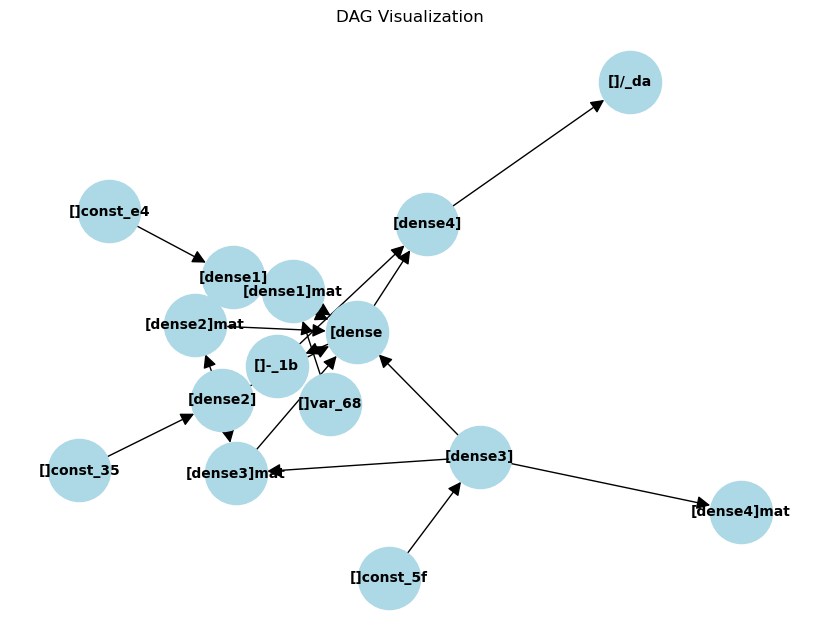

In [198]:
edges = extract_edges(model.output.get_output_node_())

# Create a directed graph using networkx
G = nx.DiGraph(directed=True)
G.add_edges_from(edges)
G_reversed = G.reverse(copy=False)
G_reversed = no_cycle_graph(G_reversed)

is_dag = nx.is_directed_acyclic_graph(G_reversed)
print("Is the graph a DAG?", is_dag)

pos = nx.spring_layout(G_reversed)
# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_reversed)  # You can change this to other layouts like nx.shell_layout, etc.
nx.draw(G_reversed, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("DAG Visualization")
plt.show()

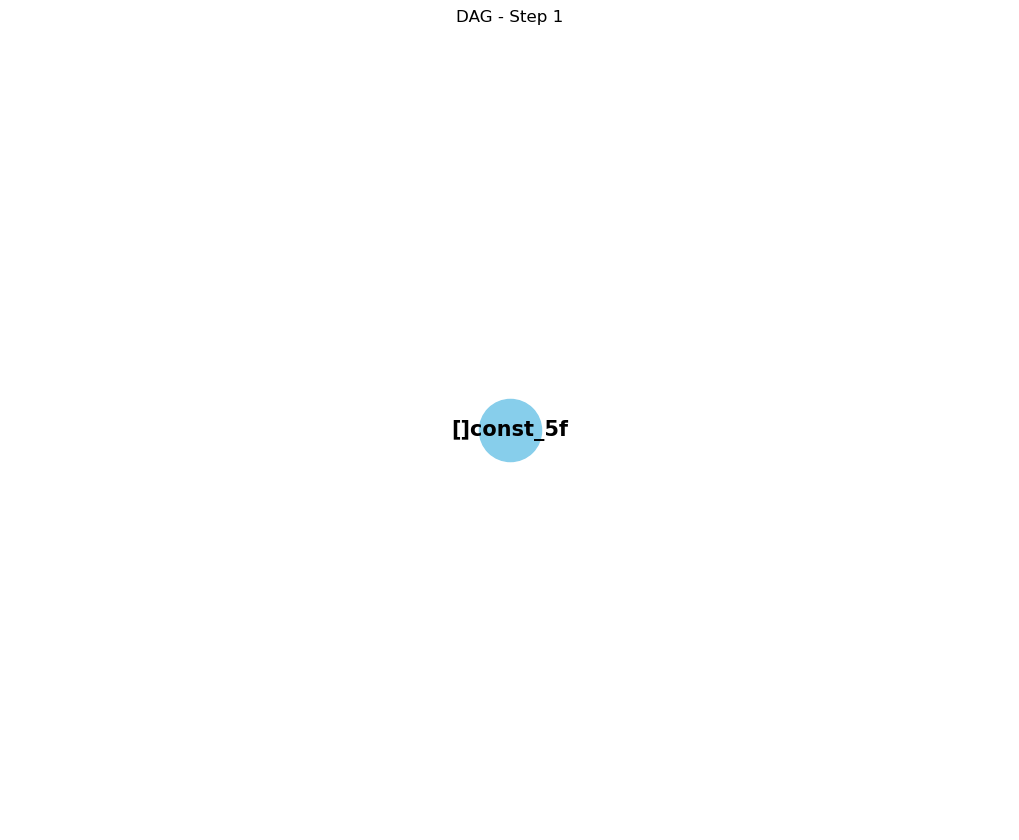

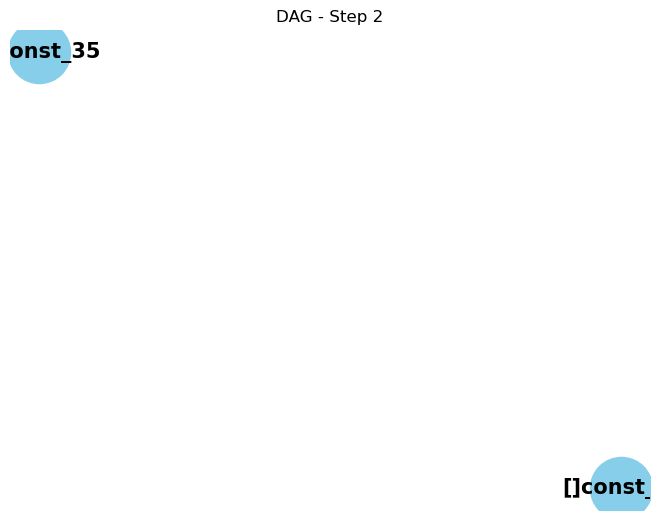

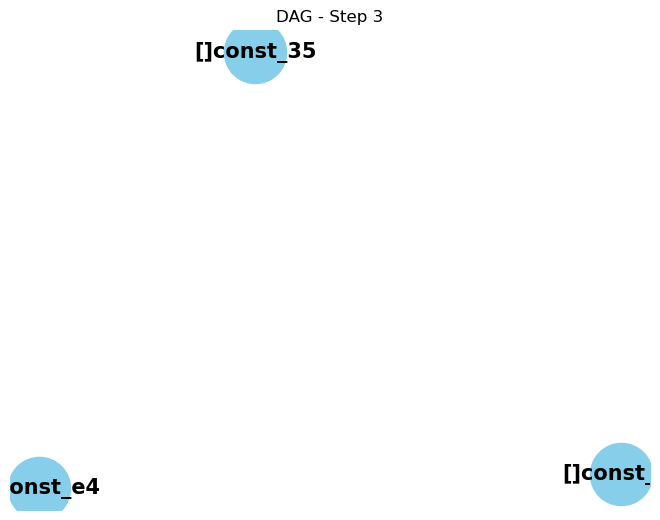

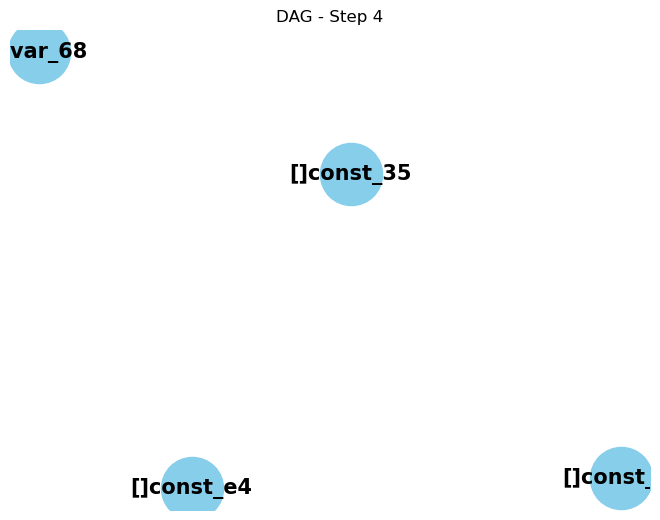

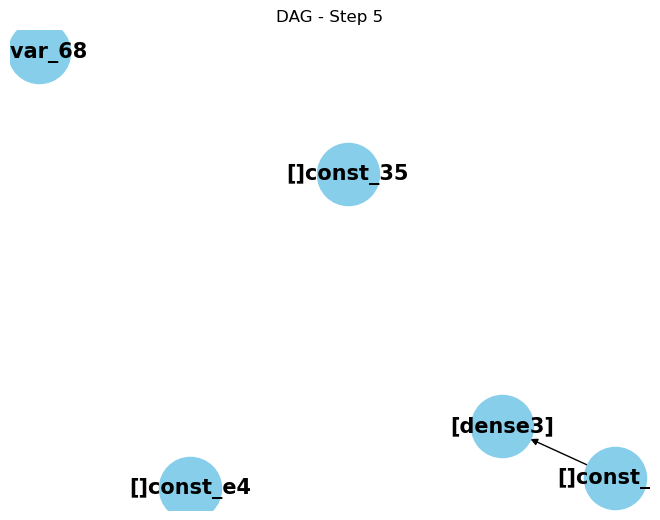

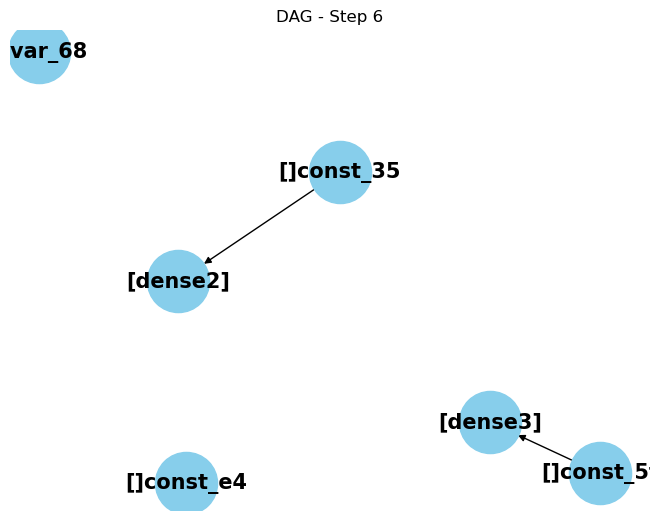

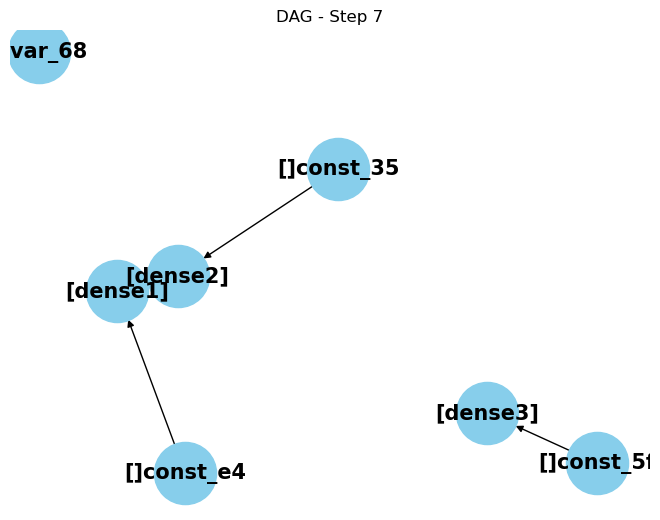

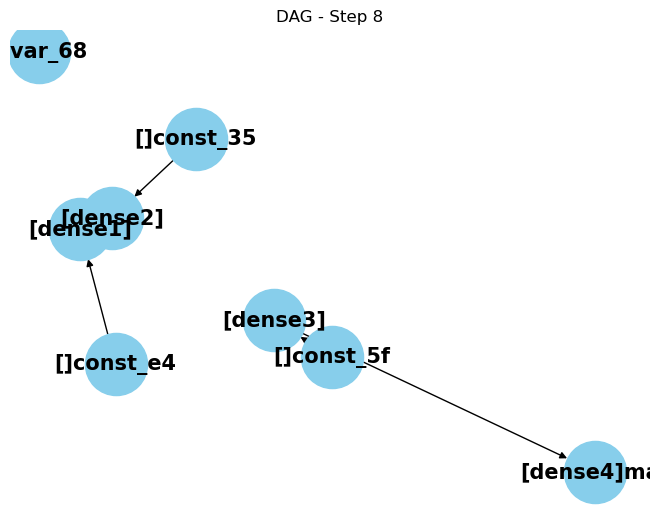

KeyboardInterrupt: 

In [199]:
def draw_dag_sequentially(G):
    G = no_cycle_graph(G)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    nodes_in_topological_order = list(nx.topological_sort(G))

    for i in range(len(nodes_in_topological_order)):
        subgraph_nodes = nodes_in_topological_order[:i + 1]
        subgraph = G.subgraph(subgraph_nodes)

        plt.clf()  # Clear the current plot
        nx.draw(subgraph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=15, font_weight="bold", arrows=True)
        plt.title(f"DAG - Step {i + 1}")
        plt.pause(1)  # Pause to display each step

    plt.show()

# Draw the DAG sequentially
draw_dag_sequentially(G_reversed)


In [ ]:
for op, _ in ordered_operations:
    op.compute()
    print(op.val)

5
5
25
0.9912028118634736
-0.008836111843672067
5
-0.9589242746631385
0.9677603865068105


In [87]:
func(5)



-0.9677603865068105